In [5]:
import pandas as pd 
from ms2rescore import plotting
from immuno_ms2rescore_tools import file_utilities
from ms2rescore.percolator import PercolatorIn
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn, pseudovenn
from functools import reduce
from collections import defaultdict
from matplotlib.patches import Patch
from ms2rescore.maxquant import MSMSAccessor

In [6]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Count number of spectra

In [7]:

mgf_files = file_utilities.MascotGenericFormat("/public/compomics/arthur/CNRS/ce_eval/mgf")
spectra_count = mgf_files.count_spectra()
spectra_count.set_index("raw file",inplace=True)

total_spectra = spectra_count.loc["total"]["spectra"]
print(total_spectra)


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]

419567


# Rescoring analysis

In [8]:
ce_path = "data/collision_energy_data/"
plotting.RescoreRecord.empty_rerecs()
pins = []
searchengines = []
ms2rescores = []
for ce_value in ["25", "27", "30", "32" ,"35"]:
    pin = plotting.PIN(ce_path+f"msms{ce_value}_searchengine_ms2pip_rt_features.pin", sample_name=f"CE_{ce_value}", score_metric="RawScore")
    pins.append(pin.df)
    searchengine = plotting.POUT(ce_path+f"msms{ce_value}_searchengine_features.pout",ce_path+f"msms{ce_value}_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name=f"CE_{ce_value}")
    searchengines.append(searchengine.df)
    ms2rescore = plotting.POUT(ce_path+f"msms{ce_value}_searchengine_ms2pip_rt_features.pout",ce_path+f"msms{ce_value}_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name=f"CE_{ce_value}")
    ms2rescores.append(ms2rescore.df)

In [9]:

plotting.RescoreRecord.empty_rerecs()

pin = plotting.PIN(ce_path+"msms25_searchengine_ms2pip_rt_features.pin", sample_name="CE", score_metric="RawScore")
searchengine = plotting.POUT(ce_path+"msms25_searchengine_features.pout",ce_path+"msms25_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name="CE")
ms2rescore = plotting.POUT(ce_path+"msms25_searchengine_ms2pip_rt_features.pout",ce_path+"msms25_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name="CE")

In [10]:
pin.df = pd.concat(pins).reset_index(drop=True)
searchengine.df = pd.concat(searchengines).reset_index(drop=True)
ms2rescore.df = pd.concat(ms2rescores).reset_index(drop=True)

In [11]:
ms2rescore.df.shape

(340277, 5)

In [12]:
accepted_targets = list(ms2rescore.df["PSMId"][(ms2rescore.df["is decoy"] == False) & (ms2rescore.df["q"] < 0.01)])
len(accepted_targets)

123129

In [13]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01],reference="Before rescoring")

# Collision energy results

In [14]:
def psmid_mapper(psmids: pd.Series, mapper: dict, separator=None):
    if separator:
        mapped_values = psmids.str.split(separator, 1, expand=True)[0].map(mapper)
    else:
        mapped_values = psmids.map(mapper)
    return mapped_values

In [15]:
summary_df = pd.read_table("data/collision_energy_data/summary.txt")
summary_df["CE"] = summary_df.Experiment.str.extract(r"CE (\d*) rep", expand=True)

In [16]:
ce_raw_map = pd.Series(summary_df.CE.values,index=summary_df["Raw file"]).to_dict()
ce_raw_map.pop("Total")

nan

In [17]:
ce_spectra_count = defaultdict(int)
for rawfile in ce_raw_map.keys():
    try:
        ce_spectra_count[ce_raw_map[rawfile]] += spectra_count.loc[rawfile]["spectra"]
    except KeyError:
        continue

In [18]:
rescoring_methods = ["no rescoring", "searchengine", "ms2rescore"]
ce_counts = []
for i, df in enumerate([pin.df, searchengine.df, ms2rescore.df]):
    rescoring_df = df.copy()
    rescoring_df["CE"] = psmid_mapper(rescoring_df.PSMId, ce_raw_map, separator=".")
    tmp = (rescoring_df[(rescoring_df["q"] < 0.01) & (rescoring_df["is decoy"] == False)]
    .groupby("CE")
    .agg({"score":"count", "peptide": list})
    .reset_index()
    .rename({"score": f"psm count {rescoring_methods[i]}","peptide": f"peptide_{rescoring_methods[i]}"}, axis=1))
    ce_counts.append(tmp)

ce_count_df = reduce(lambda left,right:pd.merge(left, right, on=["CE"], how="outer"), ce_counts)
ce_count_df = ce_count_df[["CE", "psm count no rescoring", "psm count searchengine", "psm count ms2rescore", "peptide_no rescoring", "peptide_searchengine", "peptide_ms2rescore"]]

In [19]:
ms2rescore_loss_gain = []
for i,row in ce_count_df.iterrows():
    tmp = {}
    tmp["CE"] = row.CE
    num_ids = len(set(row["peptide_searchengine"]))
    tmp["shared"] = (len(set(row["peptide_searchengine"]).intersection(set(row.peptide_ms2rescore)))/num_ids) * 100
    tmp["gain"] = (len(set(row.peptide_ms2rescore) - set(row["peptide_searchengine"]))/num_ids) * 100
    tmp["loss"] = (len(set(row["peptide_searchengine"]) - set(row.peptide_ms2rescore))/num_ids) * 100
    ms2rescore_loss_gain.append(tmp)
ms2rescore_loss_gain = pd.DataFrame(ms2rescore_loss_gain)

In [20]:
ms2rescore_loss_gain

,CE,shared,gain,loss
0,25,97.437186,41.582915,2.562814
1,27,97.638395,43.346877,2.361605
2,30,97.832981,45.269556,2.167019
3,32,97.639609,48.244099,2.360391
4,35,97.301136,59.090909,2.698864


In [21]:
ms2rescore_loss_gain["loss"] =ms2rescore_loss_gain["loss"] * -1
ms2rescore_loss_gain["gain"] =ms2rescore_loss_gain["gain"] + 100

In [22]:
# ce_count_df.sort_values("psm count no rescoring", ascending=False, inplace=True)
# ms2rescore_loss_gain = ms2rescore_loss_gain.reindex(ce_count_df["CE"].index)

# Weights analysis

In [23]:
def calculate_feature_weights(weights_file, ce):
    feature_weights = {}
    feature_weights["CE"] = ce

    weights = pd.read_table(weights_file, sep="\t")
    weights.drop([1,2,4,5,7], axis=0, inplace=True)
    weights.drop("m0", axis=1, inplace=True)
    weights = weights.astype(float)
    weights.loc["mean"] = weights.mean()

    total_weight = sum(weights.iloc[3, :71].abs()) + sum(weights.iloc[3, 71:77].abs()) + sum(weights.iloc[3, 77:].abs())
    feature_weights["MS²PIP"] = (sum(weights.iloc[3, :71].abs())  /total_weight) * 100
    feature_weights["DeepLC"] = (sum(weights.iloc[3, 71:77].abs()) /total_weight) * 100
    feature_weights["Search engine"] = (sum(weights.iloc[3, 77:].abs()) /total_weight) * 100
    
    return feature_weights

In [24]:
weights_df = pd.DataFrame([calculate_feature_weights(f"data/collision_energy_data/msms{x}_searchengine_ms2pip_rt_features.weights", x) for x in ["25", "27", "30", "32" ,"35"]])
weights_df["Search engine"] = weights_df["Search engine"] + weights_df["MS²PIP"]
weights_df["DeepLC"] = weights_df["Search engine"] + weights_df["DeepLC"]

weights_df = weights_df.reindex(ce_count_df["CE"].index)

In [25]:
fig = plt.Figure(figsize=(20,12))
order = [2,1,0]

ax1 = plt.subplot2grid((3,3),(0,0), fig=fig)

ce_id_rate = ce_count_df.copy()
ce_id_rate.iloc[:,1:4] = ce_id_rate.iloc[:,1:4].div(pd.Series(ce_spectra_count).reindex(ce_id_rate["CE"]).values, axis=0)

sns.barplot(x="psm count ms2rescore", y="CE", label="ms2rescore", data=ce_id_rate, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="CE", label="searchengine", data=ce_id_rate, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="CE", label="no rescoring", data=ce_id_rate, color="#1f77b4", ax=ax1)
handles, labels = ax1.get_legend_handles_labels()

noR = Patch(facecolor="#1f77b4", edgecolor="#1f77b4")
SE = Patch(facecolor="#ff7f0e", edgecolor="#ff7f0e")
MS = Patch(facecolor="#2ca02c", edgecolor="#2ca02c")

ax1.legend(
    [noR, noR, SE,noR,SE,MS],
    ["no rescoring    ","","searchengine    ","", "", "ms2rescore    "],
    frameon=False, 
    ncol=10, 
    bbox_to_anchor=(0.98,1.30),
    handletextpad=0.5, 
    handlelength=0.85, 
    columnspacing=-0.5
)
ax1.set_xlabel("Spectrum identification rate (%)")
sns.despine(left=True, right=True, top=True, ax=ax1)
ax1.set_title("A", loc="left")

ax2 = plt.subplot2grid((3,3),(0,1), fig=fig)

sns.barplot(
    y="CE",
    x="gain",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#2FA92D"]),
    ax=ax2,
    label="gain"
)
sns.barplot(
    y="CE",
    x="shared",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax2,
    label="shared"
)
sns.barplot(
    y="CE",
    x="loss",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#FF0000"]),
    ax=ax2,
    label="loss"
)
ax2.set_xlabel("Unique identified peptides (%)")
ax2.set_xlim(-2,165)
ax2.set_ylabel("")
ax2.set_title("B", loc="left")
ax2.set(yticklabels=[])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(0.60,1.30),
    columnspacing=0.5
)
sns.despine(left=True, right=True, top=True, ax=ax2)

ax3 = plt.subplot2grid((3,3),(0,2), fig=fig)

sns.barplot(
    y="CE",
    x="DeepLC",
    data=weights_df,
    palette=sns.color_palette(["#28ea22"]),
    ax=ax3,
    label="DeepLC"
)
sns.barplot(
    y="CE",
    x="Search engine",
    data=weights_df,
    palette=sns.color_palette(["#FFCD27"]),
    ax=ax3,
    label="Search engine"
)
sns.barplot(
    y="CE",
    x="MS²PIP",
    data=weights_df,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax3,
    label="ms2pip"
)
ax3.set_xlabel("Percolator weights (%)")
ax3.set_ylabel("")
ax3.set_title("C", loc="left")
ax3.set(yticklabels=[])
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(0.84,1.30),
    columnspacing=0.5
)
sns.despine(left=True, right=True, top=True, ax=ax3)

# Spectrum pearson correlation analysis

In [26]:
features_pin = PercolatorIn()
features_pin.df = pd.concat([PercolatorIn(f"data/collision_energy_data/msms{ce}_searchengine_ms2pip_rt_features.pin").df for ce in [25, 27, 30, 32, 35]], ignore_index=True)


In [27]:
features_pin.df = features_pin.df[features_pin.df["SpecId"].isin(accepted_targets)]
features_pin.df["CE"] = psmid_mapper(features_pin.df.SpecId, ce_raw_map, separator=".")

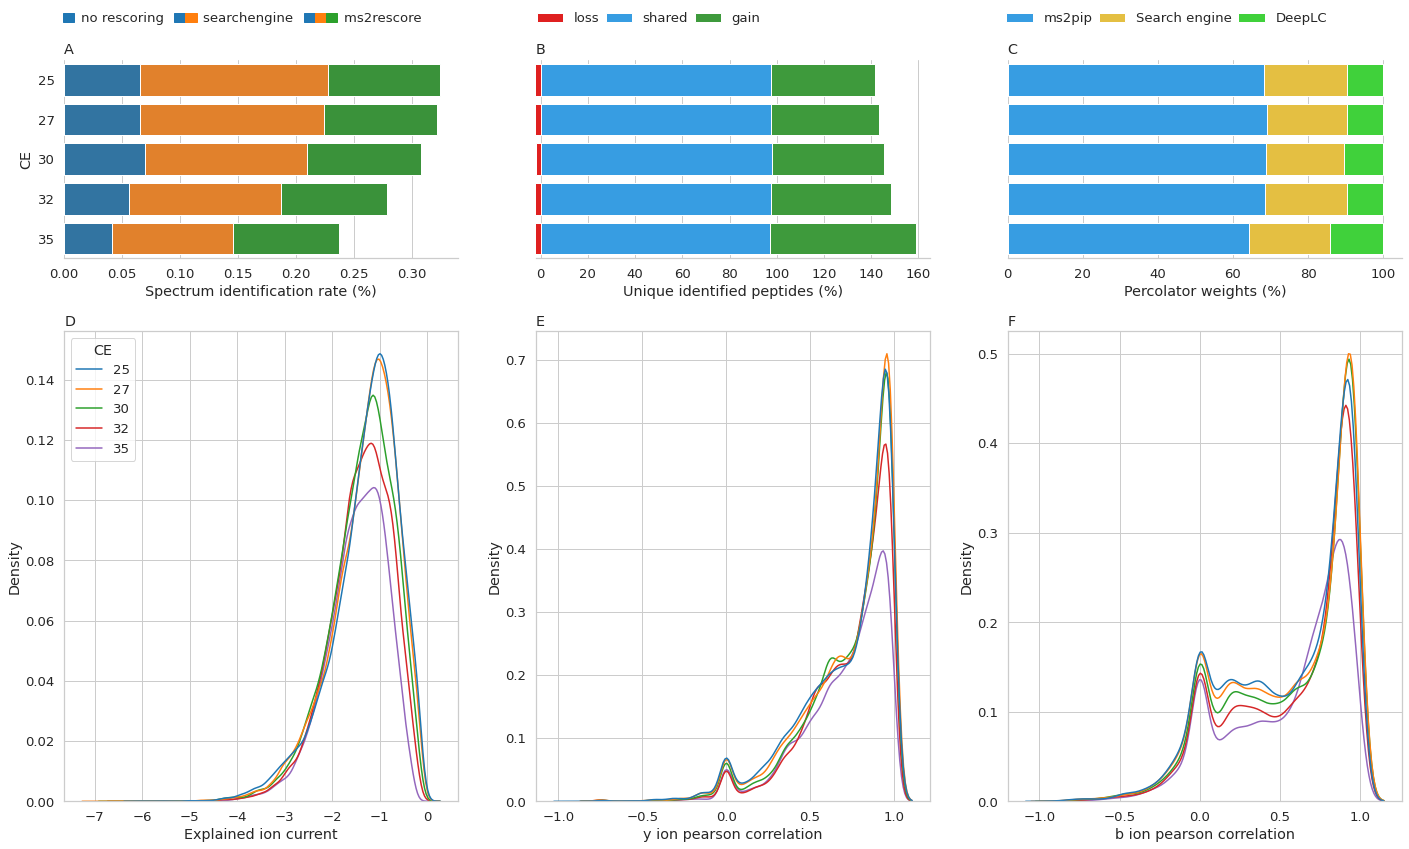

In [28]:
ax4 = plt.subplot2grid((3,3),(1,0), rowspan=2, fig=fig)
sns.kdeplot(
    x="lnExplainedIonCurrent",
    hue="CE",
    data=features_pin.df,
    common_norm=True,
    ax=ax4
)
ax4.set_xlabel("Explained ion current")
ax4.set_title("D", loc="left")
ax5 = plt.subplot2grid((3,3),(1,1), rowspan=2, fig=fig)
sns.kdeplot(
    x="iony_pearson_norm",
    hue="CE",
    data=features_pin.df,
    ax=ax5
)
ax5.set_xlabel("y ion pearson correlation")
ax5.get_legend().remove()
ax5.set_title("E", loc="left")

ax6 = plt.subplot2grid((3,3),(1,2), rowspan=2, fig=fig)
sns.kdeplot(
    x="ionb_pearson_norm",
    hue="CE",
    data=features_pin.df,
    common_norm=True,
    ax=ax6
)
ax6.set_title("F", loc="left")
ax6.get_legend().remove()
ax6.set_xlabel("b ion pearson correlation")
fig.tight_layout()
fig.savefig("data/Figures/FigureS9.svg")
fig


# Precursor intensity analysis

In [29]:
chunks = []
chunksize = 10 ** 6
with pd.read_table("data/collision_energy_data/msms.txt", chunksize=chunksize) as reader:
    for parts in reader:
        chunks.append(parts)
msms = pd.concat(chunks)

In [30]:
msms = MSMSAccessor(msms)
msms = msms.filter_rank1_psms().msms.remove_invalid_amino_acids()

Removed 126023 non-rank 1 PSMs.
Removed 50 PSMs with invalid amino acids.


In [31]:
msms["Precursor bins"] = pd.qcut(msms["Precursor Intensity"], q=10, precision=0)
intensity_bins = dict(zip([str(x) for x in range(0,10,1)],msms["Precursor bins"].cat.categories))
msms["Precursor bins"] = msms["Precursor bins"].cat.rename_categories([f"{str(x)}-{str(x+10)}" for x in range(0,100,10)])

In [32]:
msms["spec_id"] = msms["Raw file"] + "." + msms["Scan number"].astype(str) + "." + msms["Scan number"].astype(str)
intensity_map = pd.Series(msms["Precursor bins"].values, index=msms["spec_id"]).to_dict()

In [33]:
int_counts = []
for i, df in enumerate([pin.df, searchengine.df, ms2rescore.df]):
    rescoring_df = df.copy()
    rescoring_df["precursor intensity"] = psmid_mapper(rescoring_df.PSMId, intensity_map)
    tmp = (rescoring_df[(rescoring_df["q"] < 0.01) & (rescoring_df["is decoy"] == False)]
    .groupby("precursor intensity")
    .agg({"score":"count", "peptide": list})
    .reset_index()
    .rename({"score": f"psm count {rescoring_methods[i]}","peptide": f"peptide_{rescoring_methods[i]}"}, axis=1))
    int_counts.append(tmp)

int_count_df = reduce(lambda left,right:pd.merge(left, right, on=["precursor intensity"], how="outer"), int_counts)
int_count_df = int_count_df[["precursor intensity", "psm count no rescoring", "psm count searchengine", "psm count ms2rescore", "peptide_no rescoring", "peptide_searchengine", "peptide_ms2rescore"]]

In [34]:
ms2rescore_loss_gain_int = []
for i,row in int_count_df.iterrows():
    tmp = {}
    tmp["precursor intensity"] = row["precursor intensity"]
    num_ids = len(set(row["peptide_searchengine"]))
    tmp["shared"] = (len(set(row["peptide_searchengine"]).intersection(set(row.peptide_ms2rescore)))/num_ids) * 100
    tmp["gain"] = (len(set(row.peptide_ms2rescore) - set(row["peptide_searchengine"]))/num_ids) * 100
    tmp["loss"] = (len(set(row["peptide_searchengine"]) - set(row.peptide_ms2rescore))/num_ids) * 100
    ms2rescore_loss_gain_int.append(tmp)
ms2rescore_loss_gain_int = pd.DataFrame(ms2rescore_loss_gain_int)

ms2rescore_loss_gain_int["loss"] =ms2rescore_loss_gain_int["loss"] * -1
ms2rescore_loss_gain_int["gain"] =ms2rescore_loss_gain_int["gain"] + 100

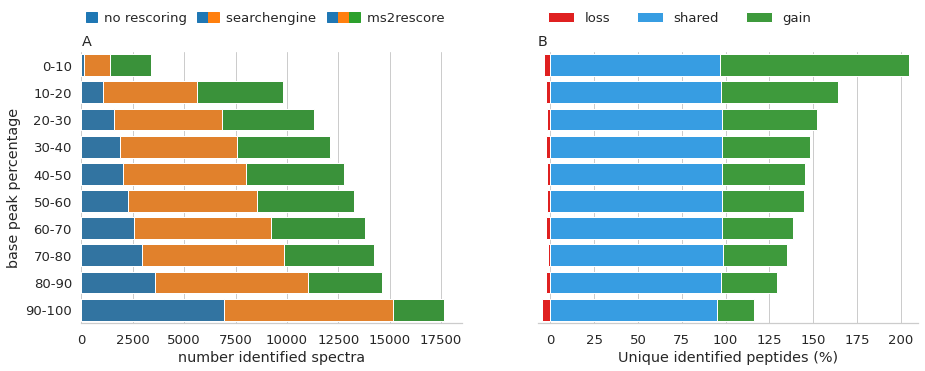

In [35]:
fig = plt.Figure(figsize=(15,5))

ax1 = fig.add_subplot(121)


sns.barplot(x="psm count ms2rescore", y="precursor intensity", label="ms2rescore", data=int_count_df, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="precursor intensity", label="searchengine", data=int_count_df, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="precursor intensity", label="no rescoring", data=int_count_df, color="#1f77b4", ax=ax1)

ax1.set_xlabel("number identified spectra")
ax1.set_ylabel("base peak percentage")
sns.despine(left=True, right=True, top=True, ax=ax1)

noR = Patch(facecolor="#1f77b4", edgecolor="#1f77b4")
SE = Patch(facecolor="#ff7f0e", edgecolor="#ff7f0e")
MS = Patch(facecolor="#2ca02c", edgecolor="#2ca02c")

ax1.legend(
    [noR, noR, SE,noR,SE,MS],
    ["no rescoring    ","","searchengine    ","", "", "ms2rescore    "],
    frameon=False, 
    ncol=10, 
    bbox_to_anchor=(1.03,1.19),
    handletextpad=0.5, 
    handlelength=0.85, 
    columnspacing=-0.5
)
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(122)

sns.barplot(
    y="precursor intensity",
    x="gain",
    data=ms2rescore_loss_gain_int,
    palette=sns.color_palette(["#2FA92D"]),
    ax=ax2,
    label="gain"
)
sns.barplot(
    y="precursor intensity",
    x="shared",
    data=ms2rescore_loss_gain_int,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax2,
    label="shared"
)
sns.barplot(
    y="precursor intensity",
    x="loss",
    data=ms2rescore_loss_gain_int,
    palette=sns.color_palette(["#FF0000"]),
    ax=ax2,
    label="loss"
)
ax2.set_xlabel("Unique identified peptides (%)")
ax2.set_ylabel("")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(0.75,1.19)
)
ax2.set_title("B", loc="left")
ax2.set(yticklabels=[])
ax2.set_xlim(-7,210)
sns.despine(left=True, right=True, top=True, ax=ax2)
fig.savefig("data/Figures/FigureS10.svg")
fig